# Load DBPedia dataset

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset

ds = load_dataset("fancyzhx/dbpedia_14")
CLASS_LABELS = ds['train'].features['label'].names
CLASS_LABELS

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.64k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/70000 [00:00<?, ? examples/s]

['Company',
 'EducationalInstitution',
 'Artist',
 'Athlete',
 'OfficeHolder',
 'MeanOfTransportation',
 'Building',
 'NaturalPlace',
 'Village',
 'Animal',
 'Plant',
 'Album',
 'Film',
 'WrittenWork']

# Obtain first n samples from each class

In [4]:
import numpy as np

In [5]:
def get_n_samples_per_class(dataset, n, shuffle = False):
    """
        Given a test dataset, select n samples from each class
        and return a smaller dataset containing all the samples.

        Args:
            dataset (Dataset): The test dataset to sample.
            n (int): How many samples from each class to extract.
            shuffle (bool): Whether to sort the final result by class or randomly. NOTE: Dataset.shuffle() hangs indefinitely on Nix.

        Returns:
            sample (Dataset): The sampled dataset.
    """
    ds_sorted = dataset.sort('label')
    _, class_indices = np.unique(ds_sorted['label'], return_index=True)


    class_indices = np.array([list(range(index, index + n)) for index in class_indices])
    class_indices = class_indices.flatten()

    if shuffle:
        sample = dataset.shuffle().sort('label').select(class_indices) # Dataset.shuffle() hangs indefinitely on Nix - No idea why.
    else:
        sample = dataset.sort('label').select(class_indices)

    if shuffle: sample = sample.shuffle() # Dataset.shuffle() hangs indefinitely on Nix - No idea why.
    return sample

In [6]:
small_dataset = get_n_samples_per_class(ds['test'], 3, shuffle=False)

# Prompt to classify articles

In [7]:
# Zero-shot prompt to classify articles and return their category ID.
PROMPT_ZEROSHOT = """You are an expert in classifying articles into categories.
Your task is to read an article, decide which category it belongs into, and then return the number of that category.
There are 14 categories you may choose from, but you can only decide one category.

CATEGORIES:
0. Company
1. Educational Institution
2. Artist
3. Athlete
4. Office Holder
5. Method Of Transportation
6. Building
7. Natural Place
8. Village
9. Animal
10. Plant
11. Album
12. Film
13. Written Work

Read the following article and return the most suitable category as a number ("0"), NOT as text ("Company").
"""

# Zero-shot chain-of-thought prompt to classify articles and return their category name.
PROMPT_COT = """You are an expert at classifying articles into the following categories:

CATEGORIES:
0. Company
1. Educational Institution
2. Artist
3. Athlete
4. Office Holder
5. Method Of Transportation
6. Building
7. Natural Place
8. Village
9. Animal
10. Plant
11. Album
12. Film
13. Written Work

Read the following article and explain which category describes its content best.
End your answer with the category name.
Let's think step by step.
"""

In [8]:
def get_classification_prompt(article, prompt):
    """
      For a given article in the Dataset,
      return a LLM prompt in chat template form
      to get its category.

      Args:
          article (Dictionary): Any item in the dataset.
          prompt (str): A model prompt with article classification instructions.

      Returns:
          prompt (Dictionary): The prompt as a [Chat Template](https://huggingface.co/docs/transformers/main/en/chat_templating).
    """
    return [
      {"role": "system", "content": prompt},
      {"role": "user", "content": article["content"].strip()},
    ]

# Load LLM

To access the LLM (C4AI Command R7B), you will need to accept a license agreement on Hugging Face.

STEPS:
1. Log into hugging face
2. Accept the license agreement [here](https://huggingface.co/CohereForAI/c4ai-command-r7b-12-2024)
3. Replace variable ``YOUR_HF_TOKEN`` with your Hugging Face token.

In [9]:
HF_TOKEN = ""

In [10]:
from accelerate.test_utils.testing import get_backend

DEVICE, _, _ = get_backend()

In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "CohereForAI/c4ai-command-r7b-12-2024"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=HF_TOKEN, device_map="auto")
model = AutoModelForCausalLM.from_pretrained(model_id, token=HF_TOKEN, device_map="auto")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/45.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/178 [00:00<?, ?B/s]

In [12]:
import transformers, torch

pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    token=HF_TOKEN,
    torch_dtype=torch.float16,
    device_map="auto",
)

Device set to use cuda:0


# Model testing method

In [26]:
LABEL_NAMES=[
    "Company",
    "Educational Institution",
    "Artist",
    "Athlete",
    "Office Holder",
    "Method Of Transportation",
    "Building",
    "Natural Place",
    "Village",
    "Animal",
    "Plant",
    "Album",
    "Film",
    "Written Work"
]

def get_class_label_from_string(string, class_labels = LABEL_NAMES):
  """
  Extract a class label by name from a string and return its ID.
  If no match is found, raise an Exception.

  Args:
    string (str): A string containing the name of one class label.

  Returns:
    class_id (int): The ID of the matching class label.
  """
  string = string.lower().strip()

  for (id, label) in enumerate(class_labels): # For each class label:
    # If we can find a direct match of the class label anywhere in the string:
    if (string.find(label.lower()) != -1):
      return id # Return the ID of the matching class label.

  raise Exception(f"No class label found in string: {string}")

In [27]:
import re

def get_first_number_from_string(string):
  """
  Returns the first whole number from a string as an integer.
  """
  first_number=re.findall(r"\d+",string)
  if first_number is not None:
    first_number = int(first_number[0])
    return first_number
  else:
    raise Exception(f"No number found in string: {string}")

def get_category_label(article, classification_prompt, extractor_func, max_tokens = 10):
  """
  For a given article in the DBPedia dataset, predict its category label.

  Args:
    article (str): Article contents as raw text.
    classifiction_prompt (str): Model instructions on how to classify articles.
    extractor_func (func): A method which takes the model's response and returns a classification label as an integer.
    max_tokens (int): Model response word limit.

  Returns:
    class_id (int): The category of the article.
  """
  input = get_classification_prompt(article, classification_prompt)

  chat_history = pipeline(
      input,
      do_sample=True,
      #top_k=10,
      #num_return_sequences=1,
      eos_token_id=tokenizer.eos_token_id,
      max_new_tokens=max_tokens,
      temperature=0.001
      #continue_final_message=continue_final_message
  )

  response = chat_history[0]["generated_text"][-1]['content']

  class_id = extractor_func(response)

  return class_id

In [28]:
from tqdm import tqdm

def predict_classes(dataset, classification_prompt, extractor_func, max_tokens):
  """
    For a given RFPedia dataset, use the contents of each article to predict its label.

    Args:
      dataset (Dataset): The dataset to sample.
      classifiction_prompt (str): Model instructions on how to classify articles.
      extractor_func (func): A method which takes the model's response and returns a classification label as an integer.
      max_tokens (int): Model response word limit.

    Returns:
      results (tuple<list, list>): Two lists: ``y_pred`` (predicted labels) and ``y_true`` (actual labels).
  """
  y_pred = []
  y_true = []

  for item in tqdm(dataset, "Classifying articles"):
    y_pred.append( get_category_label(item, classification_prompt, extractor_func, max_tokens) )
    y_true.append( item['label' ])

  return y_pred, y_true

# Test the model

In [31]:
configurations = [
    {"name" : "Zero-shot",
     "prompt" : PROMPT_ZEROSHOT,
     "max_tokens" : 10,
     "extractor_func" : get_first_number_from_string},

    {"name" : "Chain-of-Thought",
     "prompt" : PROMPT_COT,
     "max_tokens" : 100,
     "extractor_func" : get_class_label_from_string}
]

In [32]:
# Predict all article categories in the dataset

y_true = None
test_data = small_dataset

for config in tqdm(configurations, "Testing LLM configurations"):

  args = config['prompt'], config['extractor_func'], config['max_tokens']

  config['y_pred'], config['y_true'] = predict_classes(test_data, *args)

Testing LLM configurations: 100%|██████████| 2/2 [02:19<00:00, 69.62s/it]


# Evaluate the model

In [78]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

def evaluate_model(config):
  y_true, y_pred, config_name = config['y_true'], config['y_pred'], config['name']
  print(f"\n{config_name} evaluation results\n")

  # Get precision, recall, and F1 score
  classif_report = classification_report(y_true, y_pred, zero_division=0.0)

  print(classif_report)

  # Display confusion matrix
  disp = ConfusionMatrixDisplay.from_predictions(
      y_true, y_pred,
      display_labels = CLASS_LABELS,
      cmap = plt.cm.Blues,
      xticks_rotation='vertical')
  disp.ax_.set_title(config_name)


Zero-shot evaluation results

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         3
           3       1.00      0.67      0.80         3
           4       0.43      1.00      0.60         3
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         3
           7       0.43      1.00      0.60         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3
          10       0.67      0.67      0.67         3
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         3
          13       0.25      1.00      0.40         3

    accuracy                           0.48        42
   macro avg       0.38      0.48      0.38        42
weighted avg       0.38      0.48      0.38      

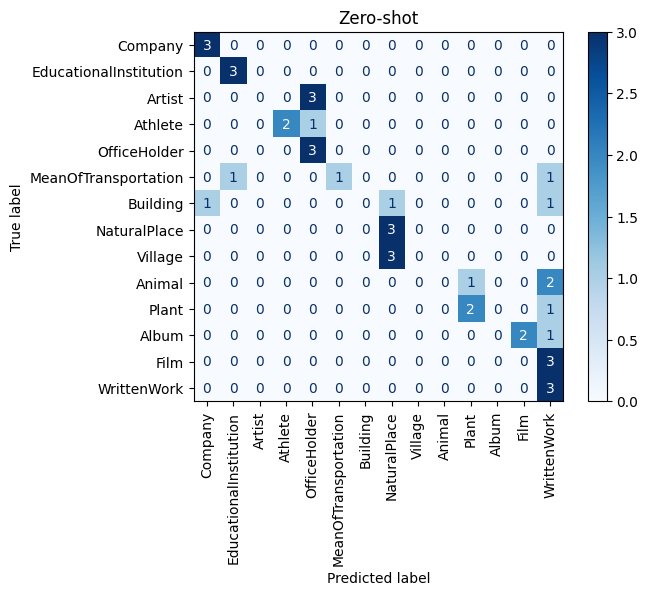

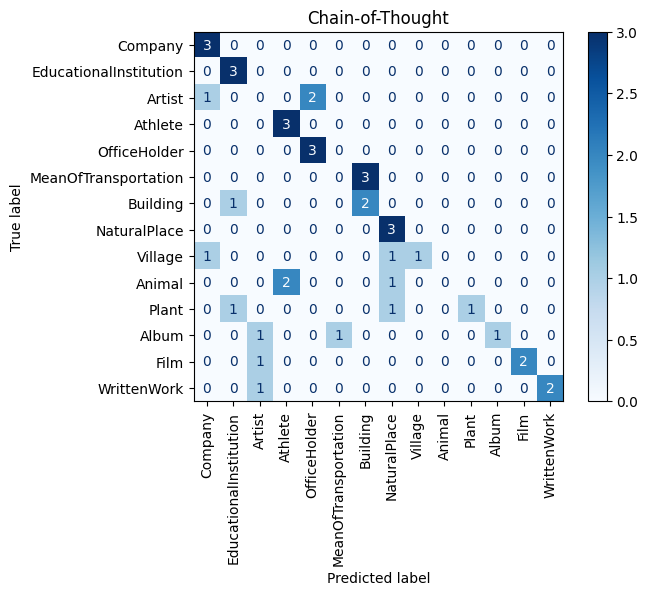

In [79]:
for config in configurations:
  evaluate_model(config)